# Introduction to the Data Analysis Report for Trivisio's Wireless Unit

#### Context and Objective

Trivisio aims to position its new Colibri Wireless unit at the forefront of the inertial measurement units (IMUs) market. This advanced product, equipped with sensors for acceleration, angular rate, magnetic field, temperature, and orientation, is set to surpass competitors such as Wireless InertiaCube3, MTw Awinda, T40s, and OptoTrak 3020.

#### Research Design

Our study analyzed data from nine participants involved in 12 to 18 physical activities like walking and football, using three IMUs and a heart-rate monitor. The dataset, in .dat files, contains 54 attributes per reading, including activity ID, heart rate, and detailed IMU data from wrist, chest, and ankle devices.

#### Hypothesis Development

The focal point of our analysis is to formulate a predictive hypothesis that leverages this rich dataset to yield actionable insights.
Given the nature of the data and the objectives of Trivisio, the proposed hypothesis is:

**"What combination of factors can predict the type of physical activity (METs) a subject is engaged in?"**

This hypothesis is underpinned by the notion that physical exertion and body movement patterns, as captured by these variables, have distinctive signatures for different activities.


#### Methodology

Our approach includes comprehensive ETL processes for data integrity, along with advanced statistical and machine learning methods for model development and validation. Emphasis will be on feature selection, data preprocessing, and model optimization to ensure robust results.

#### Expected Outcomes and Impact

The project's success is anticipated to confirm the Colibri Wireless unit's superiority over competitors and foster innovative software solutions for increased user engagement and strategic product development insights.

----------------------------------

#### Import libraries and dataset

In [3]:
import numpy as np  # Fundamental package for scientific computing with Python
import pandas as pd  # Data manipulation and analysis library
import seaborn as sns  # Statistical data visualization library
from scipy import stats  # Contains a large number of statistical distributions and functions
from sklearn import metrics  # Tools for assessing the performance of machine learning models
import statsmodels.api as sm  # Provides classes and functions for the estimation of many different statistical models
import matplotlib.pyplot as plt  # Plotting library for creating static, interactive, and animated visualizations
from sklearn.cluster import KMeans  # K-Means clustering algorithm
from scipy.stats import ks_2samp  # Kolmogorov-Smirnov test for two samples
from scipy.stats import normaltest  # Test whether a sample differs from a normal distribution
from sklearn.decomposition import PCA  # Principal Component Analysis (PCA) for dimensionality reduction
from sklearn.feature_selection import RFE  # Recursive Feature Elimination for feature selection
from sklearn.metrics import silhouette_score  # Measure of how similar an object is to its own cluster compared to other clusters
from sklearn.feature_selection import RFECV  # Recursive Feature Elimination with cross-validation
from sklearn.model_selection import train_test_split  # Split arrays or matrices into random train and test subsets
from statsmodels.stats.diagnostic import lilliefors  # Lilliefors test for normality
from sklearn.linear_model import LinearRegression  # Ordinary least squares Linear Regression
from statsmodels.distributions.empirical_distribution import ECDF  # Empirical Cumulative Distribution Function

In [4]:
def create_dataframe(data, columns):
    """Create a DataFrame from the given data and columns."""
    return pd.DataFrame(data=data, columns=columns)

def process_protocol_data(start_subject, end_subject, file_path_template, headers):
    """Read and concatenate protocol data for each subject."""
    df_protocol_raw = pd.DataFrame()
    for i in range(start_subject, end_subject + 1):
        file_path = file_path_template.format(i)
        df_protocol = pd.read_csv(file_path, names=headers, delimiter=" ")
        df_protocol.insert(loc=0, column='Subject_ID', value=f"1{i:0>2d}")
        df_protocol_raw = pd.concat([df_protocol_raw, df_protocol], axis=0)
    return df_protocol_raw

def main():
    # Subject information
    subjects_data = [[101, 'Male', 27, 182, 83, 75, 193, 'right'],
          [102, 'Female', 25, 169, 78, 74, 195, 'right'],
          [103, 'Male', 31, 187, 92, 68, 189, 'right'],
          [104, 'Male', 24, 194, 95, 58, 196, 'right'],
          [105, 'Male', 26, 180, 73, 70, 194, 'right'],
          [106, 'Male', 26, 183, 69, 60, 194, 'right'],
          [107, 'Male', 23, 173, 86, 60, 197, 'right'],
          [108, 'Male', 32, 179, 87, 66, 188, 'left'],
          [109, 'Male', 31, 168, 65, 54, 189, 'right']]
    
    subjects_columns = ['Subject_ID', 'Sex', 'Age_years', 'Height_cm', 'Weight_kg', 'Resting_HR_bpm', 'Max_HR_bpm', 'Dominant_hand']
    df_subjects = create_dataframe(subjects_data, subjects_columns)

    # Protocol information
    protocol_headers =['timestamp (seconds)','activity ID', 'heart rate (bpm)','hand - temperature', 'hand - 3D-acceleration scale: ±16g, resolution: 13-bit -1',  'hand - 3D-acceleration scale: ±16g, resolution: 13-bit -2','hand - 3D-acceleration scale: ±16g, resolution: 13-bit -3',  'hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -1','hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -2',  'hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -3','hand - 3D-gyroscope -1','hand - 3D-gyroscope -2','hand - 3D-gyroscope -3',  'hand - 3D-magnetometer -1','hand - 3D-magnetometer -2','hand - 3D-magnetometer -3','hand - orientation (invalid in this data collection) -1',  'hand - orientation (invalid in this data collection) -2','hand - orientation (invalid in this data collection) -3',  'hand - orientation (invalid in this data collection) -4','chest - temperature', 'chest - 3D-acceleration scale: ±16g, resolution: 13-bit -1',  'chest - 3D-acceleration scale: ±16g, resolution: 13-bit -2','chest - 3D-acceleration scale: ±16g, resolution: 13-bit -3',  'chest - 3D-acceleration scale: ±6g, resolution: 13-bit* -1','chest - 3D-acceleration scale: ±6g, resolution: 13-bit* -2',  'chest - 3D-acceleration scale: ±6g, resolution: 13-bit* -3','chest - 3D-gyroscope -1','chest - 3D-gyroscope -2','chest - 3D-gyroscope -3', 'chest - 3D-magnetometer -1','chest - 3D-magnetometer -2','chest - 3D-magnetometer -3','chest - orientation (invalid in this data collection) -1',  'chest - orientation (invalid in this data collection) -2','chest - orientation (invalid in this data collection) -3',  'chest - orientation (invalid in this data collection) -4','ankle - temperature' ,'ankle - 3D-acceleration scale: ±16g, resolution: 13-bit -1',  'ankle - 3D-acceleration scale: ±16g, resolution: 13-bit -2','ankle - 3D-acceleration scale: ±16g, resolution: 13-bit -3',  'ankle - 3D-acceleration scale: ±6g, resolution: 13-bit* -1','ankle - 3D-acceleration scale: ±6g, resolution: 13-bit* -2',  'ankle - 3D-acceleration scale: ±6g, resolution: 13-bit* -3','ankle - 3D-gyroscope -1','ankle - 3D-gyroscope -2','ankle - 3D-gyroscope -3',  'ankle - 3D-magnetometer -1','ankle - 3D-magnetometer -2','ankle - 3D-magnetometer -3','ankle - orientation (invalid in this data collection) -1',  'ankle - orientation (invalid in this data collection) -2','ankle - orientation (invalid in this data collection) -3',  'ankle - orientation (invalid in this data collection) -4']

    file_path_template = "C:\\Users\\user\\OneDrive - University of Sussex\\Data Science Research Method\\Final\\Dataset\\Dataset\\Protocol\\subject1{:0>2d}.dat"
    df_protocol_raw = process_protocol_data(1, 9, file_path_template, protocol_headers)

    return df_protocol_raw, df_subjects

if __name__ == "__main__":
    df_protocol_raw ,df_subjects = main()


##### Making sure the data has the correct dtype.

In [5]:
df_protocol_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2872533 entries, 0 to 8476
Data columns (total 55 columns):
 #   Column                                                      Dtype  
---  ------                                                      -----  
 0   Subject_ID                                                  object 
 1   timestamp (seconds)                                         float64
 2   activity ID                                                 int64  
 3   heart rate (bpm)                                            float64
 4   hand - temperature                                          float64
 5   hand - 3D-acceleration scale: ±16g, resolution: 13-bit -1   float64
 6   hand - 3D-acceleration scale: ±16g, resolution: 13-bit -2   float64
 7   hand - 3D-acceleration scale: ±16g, resolution: 13-bit -3   float64
 8   hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -1   float64
 9   hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -2   float64
 10  hand - 3D-acce

We expect the dataset to consist of 53 numerical columns and 2 object-type columns, specifically `subject_ID` and `activity_id`. 

Altogether, this amounts to a total of 55 columns.

In [6]:
df_protocol_raw['activity ID'] = df_protocol_raw['activity ID'].astype(str)
number_col = len(df_protocol_raw.select_dtypes(include=[np.number]).columns)
print(f"number-type columns: {number_col}")
print(f"object-type columns: {len(df_protocol_raw.columns)-number_col}")

number-type columns: 53
object-type columns: 2


In [7]:
df_protocol_raw.describe()

timestamp (seconds)  heart rate (bpm)  hand - temperature  \
count         2.872533e+06     262268.000000        2.859392e+06   
mean          1.834354e+03        109.872508        3.265258e+01   
std           1.105689e+03         25.870036        1.844274e+00   
min           5.640000e+00         57.000000        2.475000e+01   
25%           8.931600e+02         90.000000        3.143750e+01   
50%           1.790830e+03        108.000000        3.312500e+01   
75%           2.710570e+03        125.000000        3.400000e+01   
max           4.475630e+03        202.000000        3.550000e+01   

       hand - 3D-acceleration scale: ±16g, resolution: 13-bit -1  \
count                                       2.859392e+06           
mean                                       -4.960786e+00           
std                                         5.985029e+00           
min                                        -1.453670e+02           
25%                                        -9.028420e+00           
50%                                        -5.788145e+00           
75%                                        -7.829420e-01           
max                                         6.285960e+01           

       hand - 3D-acceleration scale: ±16g, resolution: 13-bit -2  \
count                                       2.859392e+06           
mean                                        3.587758e+00           
std                                         6.277838e+00           
min                                        -1.043010e+02           
25%                                         1.290268e+00           
50%                                         3.570830e+00           
75%                                         6.602720e+00           
max                                         1.556990e+02           

       hand - 3D-acceleration scale: ±16g, resolution: 13-bit -3  \
count                                       2.859392e+06           
mean                                        3.168417e+00           
std                                         3.843923e+00           
min                                        -1.014520e+02           
25%                                         9.685818e-01           
50%                                         2.958415e+00           
75%                                         6.002930e+00           
max                                         1.577600e+02           

       hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -1  \
count                                       2.859392e+06           
mean                                       -4.889420e+00           
std                                         5.992726e+00           
min                                        -6.148950e+01           
25%                                        -8.933270e+00           
50%                                        -5.737615e+00           
75%                                        -7.249920e-01           
max                                         5.282140e+01           

       hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -2  \
count                                       2.859392e+06           
mean                                        3.584267e+00           
std                                         6.055750e+00           
min                                        -6.186800e+01           
25%                                         1.284680e+00           
50%                                         3.613430e+00           
75%                                         6.601960e+00           
max                                         6.225980e+01           

       hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -3  \
count                                       2.859392e+06           
mean                                        3.349479e+00           
std                                         3.840650e+00           
min                                        -6.193470e+01 

Statistical summary of the features:

1. **Variability in Sensor Data**: 

    Hand and ankle 3D-acceleration have over 2.85 million readings. Heart rate data is much less data (only about 262,268). This suggests missing data in heart rate.

2. **Heart Rate Data**: 

    The average heart rate is about 109.87 bpm, with a standard deviation of 25.87 bpm. This range (from 57 to 202 bpm) could indicate a variety of physical activities, from rest to high-intensity exercise. The wide range and standard deviation suggest diverse activity levels among the subjects or varied measurements throughout different times.

3. **Temperature Readings**: 

    The hand temperature averages around 32.65°C, with a relatively small standard deviation, indicating fairly consistent temperature measurements.

4. **Acceleration and Gyroscope Data**: 

    The means of acceleration and gyroscope data are close to zero, especially for the gyroscope, which is expected in a balanced dataset where movements in all directions are equally likely. However, the wide range in min and max values (especially in acceleration data) suggests the presence of rapid and diverse movements.

5. **Standard Deviations in Motion Data**: 

    High standard deviations in acceleration and gyroscope data indicate variability in movement intensity. This is typical in datasets capturing different physical activities, from sedentary to highly active states.

6. **Percentiles**: 

    The 25th, 50th, and 75th percentiles provide insights into the distribution of the data. For instance, the median heart rate is 108 bpm, which might indicate that most of the recorded activities are of moderate intensity.

7. **Potential Outliers**: 

    The extreme min and max values in some sensors (like the 3D-acceleration and gyroscope data) might indicate either very intense activity or potential outliers due to sensor errors or extreme movements.

In [8]:
df_protocol_raw.duplicated().sum()

0

Our dataset has been thoroughly examined and it has been confirmed that there are no duplicate entries, ensuring the uniqueness of each data record.

In [9]:
df_protocol_raw.isnull().sum()

Subject_ID                                                          0
timestamp (seconds)                                                 0
activity ID                                                         0
heart rate (bpm)                                              2610265
hand - temperature                                              13141
hand - 3D-acceleration scale: ±16g, resolution: 13-bit -1       13141
hand - 3D-acceleration scale: ±16g, resolution: 13-bit -2       13141
hand - 3D-acceleration scale: ±16g, resolution: 13-bit -3       13141
hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -1       13141
hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -2       13141
hand - 3D-acceleration scale: ±6g, resolution: 13-bit* -3       13141
hand - 3D-gyroscope -1                                          13141
hand - 3D-gyroscope -2                                          13141
hand - 3D-gyroscope -3                                          13141
hand - 3D-magnetomet

In our review of the dataset, we have taken the advice from the Data collection file and have identified a significant number of null values. 

To address this and enhance data quality, we should consider the guidelines set forth in the data collection protocol:

1. **Removal of Transition Data**: The dataset includes 24 numbered activities, with '0' used for transition periods between these activities. To maintain data integrity and relevance, it is advisable to remove entries where the `activity ID` is equal to 0. This step will help in focusing on meaningful activity data.

2. **Preference for First Accelerometer Data**: Due to the saturation of acceleration data over 6g during high-impact movements, such as running, the data from the first accelerometer (calibrated to a scale of ±16g) should be prioritized. This accelerometer is less prone to saturation under high acceleration and, therefore, provides more reliable readings.

3. **Column Removal for Invalid Data**: Any columns labeled with `invalid in this data collection` in their title should be dropped from the dataset. These columns are presumably either not relevant to our analysis or contain data that is not reliable or applicable for our purposes.

In [10]:
def exclude_transient_activities(df, activity_id_col='activity ID'):
    """
    Exclude transient activities from the dataset.
    Removes rows where the specified activity ID equals 0, focusing on sustained activities.
    
    :param df: Pandas DataFrame containing the dataset.
    :param activity_id_col: String, name of the column containing activity IDs.
    :return: Pandas DataFrame with transient activities excluded.
    """
    return df[df[activity_id_col] != '0']

def remove_mismatched_frequency_columns(df, regex_pattern='scale: ±6g'):
    """
    Remove columns with imprecise data due to frequency mismatch.
    Targets and drops columns where the IMU and heart rate monitors' data frequencies don't align.

    :param df: Pandas DataFrame containing the dataset.
    :param regex_pattern: String, regex pattern to match columns for removal.
    :return: Pandas DataFrame with specified columns removed.
    """
    return df.drop(columns=df.filter(regex=regex_pattern))

def eliminate_invalid_orientation_columns(df, regex_pattern="invalid in this data collection"):
    """
    Eliminate columns with invalid orientation data.
    Removes columns labeled as 'invalid in this data collection', ensuring data validity.

    :param df: Pandas DataFrame containing the dataset.
    :param regex_pattern: String, regex pattern to match columns for removal.
    :return: Pandas DataFrame with specified columns removed.
    """
    return df.drop(columns=df.filter(regex=regex_pattern))

def count_missing_values(df, column_name='heart rate (bpm)'):
    """
    Calculate the count of missing values in a specified column.
    Addresses discrepancies due to differing data recording frequencies between devices.

    :param df: Pandas DataFrame containing the dataset.
    :param column_name: String, name of the column to count missing values.
    :return: Integer, count of missing values in the specified column.
    """
    return df[column_name].isna().sum()

df_protocol_raw = exclude_transient_activities(df_protocol_raw)
df_protocol_raw = remove_mismatched_frequency_columns(df_protocol_raw)
df_protocol_raw = eliminate_invalid_orientation_columns(df_protocol_raw)
missing_heart_count = count_missing_values(df_protocol_raw)

print(f"There are {missing_heart_count:,} missing heart rate records due to difference in frequency.")

There are 1,765,464 missing heart rate records due to difference in frequency.


In [11]:
df_protocol_raw

Subject_ID  timestamp (seconds) activity ID  heart rate (bpm)  \
2928        101                37.66           1               NaN   
2929        101                37.67           1               NaN   
2930        101                37.68           1               NaN   
2931        101                37.69           1               NaN   
2932        101                37.70           1             100.0   
...         ...                  ...         ...               ...   
7959        109                95.06          24               NaN   
7960        109                95.07          24               NaN   
7961        109                95.08          24               NaN   
7962        109                95.09          24             162.0   
7963        109                95.10          24               NaN   

      hand - temperature  \
2928              30.375   
2929              30.375   
2930              30.375   
2931              30.375   
2932              30.375   
...                  ...   
7959              25.125   
7960              25.125   
7961              25.125   
7962              25.125   
7963              25.125   

      hand - 3D-acceleration scale: ±16g, resolution: 13-bit -1  \
2928                                            2.21530           
2929                                            2.29196           
2930                                            2.29090           
2931                                            2.21800           
2932                                            2.30106           
...                                                 ...           
7959                                            4.99466           
7960                                            5.02764           
7961                                            5.06409           
7962                                            5.13914           
7963                                            5.00812           

      hand - 3D-acceleration scale: ±16g, resolution: 13-bit -2  \
2928                                            8.27915           
2929                                            7.67288           
2930                                            7.14240           
2931                                            7.14365           
2932                                            7.25857           
...                                                 ...           
7959                                            6.01881           
7960                                            5.90369           
7961                                            5.71370           
7962                                            5.63724           
7963                                            5.40645           

      hand - 3D-acceleration scale: ±16g, resolution: 13-bit -3  \
2928                                            5.58753           
2929                                            5.74467           
2930                                            5.82342           
2931                                            5.89930           
2932                                            6.09259           
...                                                 ...           
7959                                            5.59830           
7960                                            5.48372           
7961                                            5.48491           
7962                                            5.48629           
7963                                            5.02326           

      hand - 3D-gyroscope -1  hand - 3D-gyroscope -2  ...  \
2928               -0.004750                0.037579  ...   
2929               -0.171710                0.025479  ...   
2930               -0.238241                0.011214  ...   
2931               -0.192912                0.019053  ...   
2932               -0.069961               -0.018328  ...   
...                      ...                  

The data providers have highlighted a limitation regarding the precision of the heart rate monitor. Specifically, there is a disparity in the data collection frequencies between the heart rate monitor and the IMU sensors. While the IMUs recorded data at a high frequency of 100 readings per second, the heart rate monitor did so at a lower rate of only nine readings per second. This discrepancy has resulted in approximately 90.87% of the heart rate data being missing.

After excluding the data, we observed a total of 1,765,464 missing heart rate records, attributable to this frequency mismatch.

To address these missing values, we employed the 'bfill' (backward fill) method in our data processing strategy. This technique is particularly suited for filling gaps in datasets, where it replaces each missing value (NaN) with the subsequent non-null value found in the column.

reference: https://www.geeksforgeeks.org/python-pandas-dataframe-bfill/

This approach is justified for heart rate data, which typically demonstrates temporal continuity — the heart rate at a given moment is often close to its value at adjacent time points. By leveraging this characteristic, the bfill method assumes that heart rate changes are gradual, thus making the subsequent value a reasonable approximation for the missing one."

In [12]:
def backward_fill_missing_values(df, column_name='heart rate (bpm)'):
    """
    Backward fill missing values in a specified column.
    Replaces missing values with the next available value in the column.
    
    :param df: Pandas DataFrame containing the dataset.
    :param column_name: String, the name of the column to fill missing values.
    :return: Pandas DataFrame with missing values backward filled.
    """
    df_filled = df.copy()
    df_filled[column_name] = df_filled[column_name].fillna(method='bfill')
    return df_filled

def count_incomplete_records(df):
    """
    Count the number of records having any missing values.
    
    :param df: Pandas DataFrame containing the dataset.
    :return: Integer, count of records with one or more missing values.
    """
    return df.isna().any(axis=1).sum()

def remove_incomplete_records(df):
    """
    Remove any records that have missing values.
    Ensures that the resulting dataset contains only complete records.

    :param df: Pandas DataFrame containing the dataset.
    :return: Pandas DataFrame with incomplete records removed.
    """
    return df.dropna()

df_heart_fill = backward_fill_missing_values(df_protocol_raw)
incomplete_records_count = count_incomplete_records(df_heart_fill)
data_set_size = df_heart_fill.shape[0]

print(f"After filling the missing heart data, there are {incomplete_records_count:,} records missing one or more values, "
      f"out of a data set of size {data_set_size:,}.")

df_master = remove_incomplete_records(df_heart_fill)

After filling the missing heart data, there are 21,442 records missing one or more values, out of a data set of size 1,942,872.


In [13]:
del df_heart_fill
del df_protocol_raw
df_master.isnull().sum().any()

False

# Data Wrangling

The convention simplifies the column names by using underscores instead of spaces, abbreviates sensor types, and clearly indicates the sensor position (hand, chest, ankle) and measurement axis (x, y, z).

In [14]:
df_master.rename(columns={
    'Subject_ID': 'subject_id',
    'timestamp (seconds)': 'timestamp_seconds',
    'activity ID': 'activity_id',
    'heart rate (bpm)': 'heart_rate_bpm',
    'hand - temperature': 'hand_temperature',
    'hand - 3D-acceleration scale: ±16g, resolution: 13-bit -1': 'hand_acceleration_x',
    'hand - 3D-acceleration scale: ±16g, resolution: 13-bit -2': 'hand_acceleration_y',
    'hand - 3D-acceleration scale: ±16g, resolution: 13-bit -3': 'hand_acceleration_z',
    'hand - 3D-gyroscope -1': 'hand_gyroscope_x',
    'hand - 3D-gyroscope -2': 'hand_gyroscope_y',
    'hand - 3D-gyroscope -3': 'hand_gyroscope_z',
    'hand - 3D-magnetometer -1': 'hand_magnetometer_x',
    'hand - 3D-magnetometer -2': 'hand_magnetometer_y',
    'hand - 3D-magnetometer -3': 'hand_magnetometer_z',
    'chest - temperature': 'chest_temperature',
    'chest - 3D-acceleration scale: ±16g, resolution: 13-bit -1': 'chest_acceleration_x',
    'chest - 3D-acceleration scale: ±16g, resolution: 13-bit -2': 'chest_acceleration_y',
    'chest - 3D-acceleration scale: ±16g, resolution: 13-bit -3': 'chest_acceleration_z',
    'chest - 3D-gyroscope -1': 'chest_gyroscope_x',
    'chest - 3D-gyroscope -2': 'chest_gyroscope_y',
    'chest - 3D-gyroscope -3': 'chest_gyroscope_z',
    'chest - 3D-magnetometer -1': 'chest_magnetometer_x',
    'chest - 3D-magnetometer -2': 'chest_magnetometer_y',
    'chest - 3D-magnetometer -3': 'chest_magnetometer_z',
    'ankle - temperature': 'ankle_temperature',
    'ankle - 3D-acceleration scale: ±16g, resolution: 13-bit -1': 'ankle_acceleration_x',
    'ankle - 3D-acceleration scale: ±16g, resolution: 13-bit -2': 'ankle_acceleration_y',
    'ankle - 3D-acceleration scale: ±16g, resolution: 13-bit -3': 'ankle_acceleration_z',
    'ankle - 3D-gyroscope -1': 'ankle_gyroscope_x',
    'ankle - 3D-gyroscope -2': 'ankle_gyroscope_y',
    'ankle - 3D-gyroscope -3': 'ankle_gyroscope_z',
    'ankle - 3D-magnetometer -1': 'ankle_magnetometer_x',
    'ankle - 3D-magnetometer -2': 'ankle_magnetometer_y',
    'ankle - 3D-magnetometer -3': 'ankle_magnetometer_z'
}, inplace=True)


Guided by the protocols outlined in 'Data Collection for General Activity Monitoring,' we have undertaken the task of correlating each activity id with the corresponding average Metabolic Equivalent of Task (MET) score. 

The MET is a standardized unit employed to estimate the energy expenditure of various physical activities. It serves as a practical tool for comparing the energy intensity of different activities relative to the resting metabolic rate. For a comprehensive understanding of MET and its applications, readers are referred to a detailed resource available at (https://www.healthline.com/health/what-are-mets#definition).

In the subsequent stages of our analysis, these MET scores will be utilized as dependent variables. Our objective is to construct a predictive model that effectively utilizes these scores to understand and quantify the energy expenditure associated with various physical activities recorded in our dataset.


In [15]:
# calculating METs
subject_weights=dict(zip(df_subjects['Subject_ID'],df_subjects['Weight_kg']))
activity_MET_dict={'1':1,'2':1.8,'3':1.8,'4':3.55,'5':7.5,'6':4,'7':5.5,'9':1,'10':1.8,'11':1.8,'12':8,'13':3,'16':3.5,'17':2.3,'18':2.3,'19':3.5,'20':7.5,'24':9}

MET=df_master['activity_id'].map(activity_MET_dict)
df_master.insert(loc=2,column='MET',value=MET)

In this process, we have integrated the subjects' data with the primary dataset, `df_master`. 

This will help us understand more of the subject-specific information for the later analysis.

We did one-hot encoding on the 'sex' and 'dominant_hand' categories. 
This encoding technique transforms these categorical variables into binary columns, simplifying their representation and making the data more suitable for analytical models. 

We retained only one binary column for each original categorical variable to avoid redundancy. 

In [16]:
# merging subjects'info with exercise info
df_subjects['Subject_ID'] = df_subjects['Subject_ID'].astype('str')
df_sub_exc = pd.merge(df_master,df_subjects,right_on='Subject_ID',left_on='subject_id',how='inner')
df_sub_exc.rename(columns={'Sex':'sex','Age_years':'age','Height_cm	':'hight_cm','Weight_kg':'weight_kg','Resting_HR_bpm':'resting_HR_bpm','Max_HR_bpm':'max_HR_bpm','Dominant_hand':'dom_hand'},inplace=True)
df_sub_exc.drop('Subject_ID',axis=1,inplace=True)

# Applying one-hot encoding to 'sex' and 'dominant_hand'
df_sub_exc = pd.get_dummies(df_sub_exc, columns=['sex', 'dom_hand'])

# Converting the data types of the dummy columns to integers
df_sub_exc[['sex_Female', 'sex_Male', 'dom_hand_left', 'dom_hand_right']] = df_sub_exc[['sex_Female', 'sex_Male', 'dom_hand_left', 'dom_hand_right']].astype(int)

# Drop the extra columns (We just need one of the representives)
df_sub_exc.drop(['sex_Male','dom_hand_left'],axis=1,inplace=True)
del df_master
df_sub_exc

subject_id  timestamp_seconds  MET activity_id  heart_rate_bpm  \
0              101              37.66  1.0           1           100.0   
1              101              37.67  1.0           1           100.0   
2              101              37.68  1.0           1           100.0   
3              101              37.69  1.0           1           100.0   
4              101              37.70  1.0           1           100.0   
...            ...                ...  ...         ...             ...   
1921425        109              95.05  9.0          24           162.0   
1921426        109              95.06  9.0          24           162.0   
1921427        109              95.07  9.0          24           162.0   
1921428        109              95.08  9.0          24           162.0   
1921429        109              95.09  9.0          24           162.0   

         hand_temperature  hand_acceleration_x  hand_acceleration_y  \
0                  30.375              2.21530              8.27915   
1                  30.375              2.29196              7.67288   
2                  30.375              2.29090              7.14240   
3                  30.375              2.21800              7.14365   
4                  30.375              2.30106              7.25857   
...                   ...                  ...                  ...   
1921425            25.125              4.92309              6.02039   
1921426            25.125              4.99466              6.01881   
1921427            25.125              5.02764              5.90369   
1921428            25.125              5.06409              5.71370   
1921429            25.125              5.13914              5.63724   

         hand_acceleration_z  hand_gyroscope_x  ...  ankle_magnetometer_x  \
0                    5.58753         -0.004750  ...              -61.1081   
1                    5.74467         -0.171710  ...              -60.8916   
2                    5.82342         -0.238241  ...              -60.3407   
3                    5.89930         -0.192912  ...              -60.7646   
4                    6.09259         -0.069961  ...              -60.2040   
...                      ...               ...  ...                   ...   
1921425              5.71268         -0.303344  ...              -45.6491   
1921426              5.59830         -0.289166  ...              -45.7855   
1921427              5.48372         -0.275411  ...              -46.0331   
1921428              5.48491         -0.289885  ...              -45.5140   
1921429              5.48629         -0.234417  ...              -45.9093   

         ankle_magnetometer_y  ankle_magnetometer_z  age  Height_cm  \
0                  -36.863600            -58.369600   27        182   
1                  -36.319700            -58.365600   27        182   
2                  -35.784200            -58.611900   27        182   
3                  -37.102800            -57.879900   27        182   
4                  -37.122500            -57.884700   27        182   
...                       ...                   ...  ...        ...   
1921425             -1.095180              0.114311   31        168   
1921426             -0.831734             -0.170139   31        168   
1921427             -0.817288              0.538134   31        168   
1921428             -1.229410              0.540438   31        168   
1921429             -0.565555              0.680109   31        168   

         weight_kg  resting_HR_bpm  max_HR_bpm  sex_Female  dom_hand_right  
0               83              75         193           0               1  
1               83              75         193           0               1  
2               83              75         193           0               1  
3               83              75         193           0               1  
4               83              75         193           0               1  
...            ...        

# EDA

Outliers have been identified in the dataset. However, we will not remove these outliers, as they may be a result of natural variation. 

It is important to recognize that outliers are not necessarily errors or anomalies; in some cases, they can provide valuable insights into the data.

In [17]:
def count_outliers_iqr(data):
    outlier_counts = pd.Series(index=data.columns)
    for col in data.columns:
        if data[col].dtype in ['float64', 'int64']:  # Check if the column is numeric
            # Calculate Q1, Q3, and IQR
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1

            # Determine the bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Count outliers in the column
            outlier_counts[col] = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
    return outlier_counts

count_outliers_iqr(df_sub_exc)


subject_id                   NaN
timestamp_seconds            0.0
MET                     260313.0
activity_id                  NaN
heart_rate_bpm           10733.0
hand_temperature         20710.0
hand_acceleration_x      20735.0
hand_acceleration_y     124829.0
hand_acceleration_z      30491.0
hand_gyroscope_x        317574.0
hand_gyroscope_y        336643.0
hand_gyroscope_z        428030.0
hand_magnetometer_x       6367.0
hand_magnetometer_y      25264.0
hand_magnetometer_z      20533.0
chest_temperature            0.0
chest_acceleration_x    124568.0
chest_acceleration_y    206015.0
chest_acceleration_z    192195.0
chest_gyroscope_x       293520.0
chest_gyroscope_y       311967.0
chest_gyroscope_z       276111.0
chest_magnetometer_x     32986.0
chest_magnetometer_y    207646.0
chest_magnetometer_z      9918.0
ankle_temperature        27012.0
ankle_acceleration_x    648027.0
ankle_acceleration_y    319191.0
ankle_acceleration_z    137650.0
ankle_gyroscope_x       545828.0
ankle_gyro

In the below histogram, we went deeper into the dataset by specifically examining the distribution patterns of two key variables: heart rate and subject ID.

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


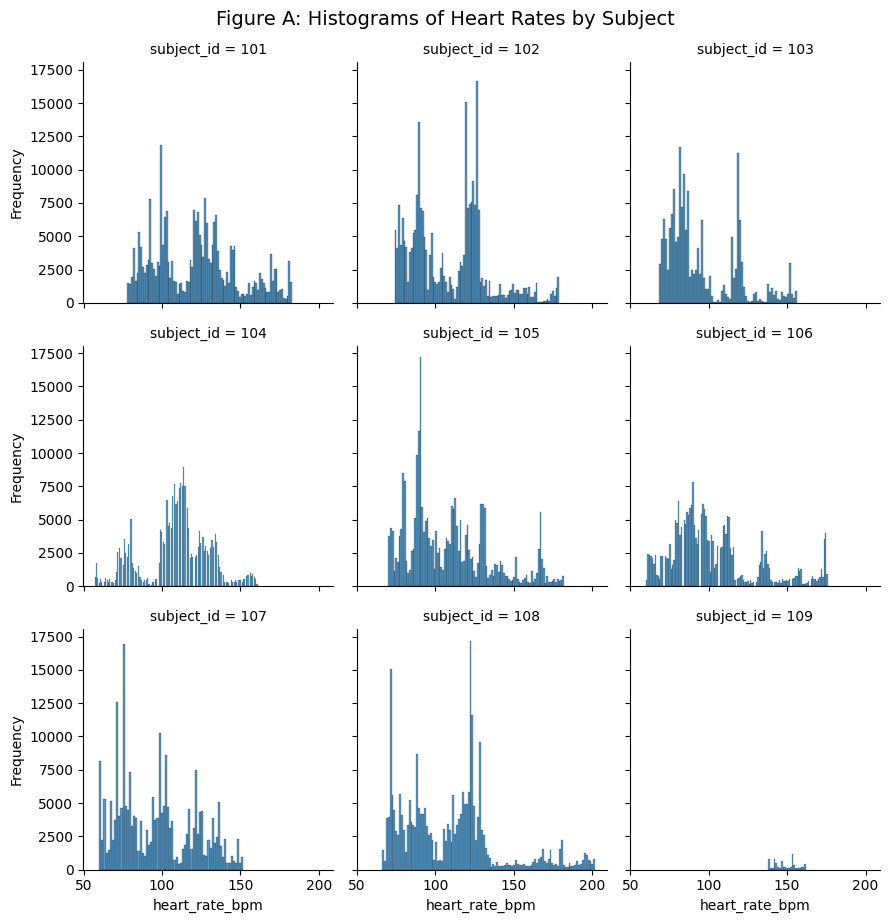

In [18]:
# Creating FacetGrid to plot histograms of heart rate for each subject
g = sns.FacetGrid(df_sub_exc[['subject_id', 'heart_rate_bpm']], col='subject_id', col_wrap=3)
g.map(sns.histplot, "heart_rate_bpm")  # Mapping the histograms for 'heart_rate_bpm'
g.set_axis_labels("heart_rate_bpm", "Frequency")  # Setting axis labels

# Setting the title for the figure with adjusted position and font size
g.fig.suptitle('Figure A: Histograms of Heart Rates by Subject', x=0.5, y=1.02, fontsize=14)

# Formatting the y-axis labels to have no decimal places
import matplotlib.ticker as ticker
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}'))


The heart rate histograms shown in Figure A for 9 subjects reveal 2 peaks in most cases. Specifically, Subjects 101, 102, 103, 104, and 108 exhibit two distinct heart rate levels. This pattern suggests a common tendency among subjects to maintain the heart rate during sedentary activities and more physically demanding activities. Subject 109 has no enough data to be considered.

In [19]:
active_sedentary = df_sub_exc['MET'].apply(lambda x:'active' if x>3 else 'sedentary')
df_sub_exc.insert(loc=2,column='active_or_sedentary',value=active_sedentary)

df_sub_exc_active_sedentary = df_sub_exc[df_sub_exc['active_or_sedentary'] == 'sedentary']
df_sub_exc_active_active = df_sub_exc[df_sub_exc['active_or_sedentary'] == 'active']

df_sub_exc_active_sedentary = df_sub_exc_active_sedentary.select_dtypes(include=[np.number])
df_sub_exc_active_active = df_sub_exc_active_active.select_dtypes(include=[np.number])

In order to further analyze the distinct difference in the sample data, we seperate the dataset into two groups(`active` with MET > 3,`sedentary` with MET<=3). 

Here's why we separated the dataset into 'active' and 'sedentary' groups based on MET values of 3:

1. **Standard MET Thresholds**:
   - In the context of physical activity, MET values are often categorized into intensity levels: light (< 3 METs), moderate (3-6 METs), and vigorous (> 6 METs). The threshold of 3 METs is widely recognized as the boundary between light and moderate intensity. This categorization is supported by organizations such as the American College of Sports Medicine and the Centers for Disease Control and Prevention.

2. **Practical Application**:
   - Using 3 METs as a threshold allows for a clear differentiation between activities that are generally considered to be either sedentary or lightly active (such as sitting, standing, or slow walking) and those that are more physically engaging (like brisk walking, dancing, or casual biking).

In the analysis, separating the groups using the 3 MET threshold would involve:

- **Active Group (MET > 3)**: This group will contain activities that are of moderate or vigorous intensity. Analyzing this group can provide insights into factors associated with more physically demanding activities.

- **Sedentary Group (MET ≤ 3)**: This group will encompass light-intensity activities, including sedentary behaviors. Analyzing this group can help in understanding the characteristics of activities with low energy expenditure.

By making this distinction, the analysis can focus on identifying the key differences and potential correlations between these two groups, such as how heart rate or other physiological parameters may vary with activity intensity. 

reference: https://en.wikipedia.org/wiki/Metabolic_equivalent_of_task

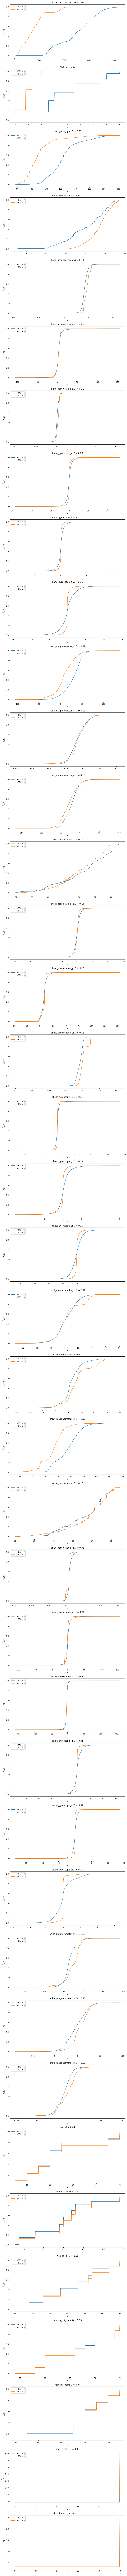

In [ ]:
# Define function for plotting ECDF
def plot_ecdf(ax, high_data, low_data, column, thresh, xlabel, ylabel):
    high_ecdf = ECDF(high_data[column])
    low_ecdf = ECDF(low_data[column])
    x_values = np.linspace(min(high_data[column].min(), low_data[column].min()), 
                           max(high_data[column].max(), low_data[column].max()), 1001)
    ax.plot(x_values, high_ecdf(x_values), label=rf"$METs > {thresh}$")
    ax.plot(x_values, low_ecdf(x_values), label=fr"$METs \leq {thresh}$")
    ax.legend(loc="best")
    D = np.max(np.abs(high_ecdf(x_values) - low_ecdf(x_values)))
    ax.set_title(fr"{column}: $D$ = {D:.2f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

fig_width = 10
fig_height_per_row = 5  
thresh = 3 
# Create subplots with appropriate size
fig, axes = plt.subplots(nrows=len(df_sub_exc_active_active.columns), ncols=1, figsize=(fig_width, fig_height_per_row * len(df_sub_exc_active_active.columns)))

for idx, col in enumerate(df_sub_exc_active_active.columns):
    standard = [fr"$METs > {thresh}$", fr"$METs \leq {thresh}$"]
    plot_ecdf(axes[idx], df_sub_exc_active_active, df_sub_exc_active_sedentary, col, thresh, r"$x$", r"$\hat{F}_{X}(x)$")
    
plt.tight_layout()
plt.show()


For each attribute under consideration, we construct Empirical Cumulative Distribution Functions (ECDFs) for both the active and sedentary groups. This approach facilitates a detailed comparison of feature distributions within these two distinct cohorts.

The Kolmogorov-Smirnov (KS) test is employed to compare these samples, with the aim of detecting any differences in the distributions. The test statistic, denoted as \(D\), is defined as:

\begin{align*}
    D = \sup\limits_x |\hat{F}_{X_1}(x) - \hat{F}_{X_2}(x)|
\end{align*}

Here, \(D\) quantifies the maximum disparity observed between the ECDFs of the two groups. A higher value of \(D\) suggests a more pronounced difference between the sample distributions, which helps identify features that are associated with either the active or sedentary MET groups.

In [ ]:
# Set the significance level for the KS test
alpha = 0.001
# Initialize an empty list to store column names where distributions differ significantly
sig_cols = [] 

for idx, col in enumerate(df_sub_exc_active_sedentary.columns):
    # Perform the KS test between the high profit and low profit groups for each column
    _, p_value_ks = ks_2samp(df_sub_exc_active_active[col], df_sub_exc_active_sedentary[col])

    # Check if the p-value is less than the significance level
    if p_value_ks < alpha:
        # If it is, print a statement indicating significant difference and add the column name to sig_cols
        print(f"KS: The Sedentary and Active MET score distributions are significantly different for {col} at the {100*alpha}% significance level, p-value = {p_value_ks}")
        sig_cols.append(col)
    else:
        # If not, print a statement indicating no significant difference
        print(f"KS: The Sedentary and Active MET score distributions are not significantly different for {col} at the {100*alpha}% significance level, p-value = {p_value_ks}")


KS: The Sedentary and Active MET score distributions are significantly different for timestamp_seconds at the 0.1% significance level, p-value = 0.0
KS: The Sedentary and Active MET score distributions are significantly different for MET at the 0.1% significance level, p-value = 0.0
KS: The Sedentary and Active MET score distributions are significantly different for heart_rate_bpm at the 0.1% significance level, p-value = 0.0
KS: The Sedentary and Active MET score distributions are significantly different for hand_temperature at the 0.1% significance level, p-value = 0.0
KS: The Sedentary and Active MET score distributions are significantly different for hand_acceleration_x at the 0.1% significance level, p-value = 0.0
KS: The Sedentary and Active MET score distributions are significantly different for hand_acceleration_y at the 0.1% significance level, p-value = 0.0
KS: The Sedentary and Active MET score distributions are significantly different for hand_acceleration_z at the 0.1% sig

In [107]:
df_sub_exc_active_active['Group'] = 'Active'
df_sub_exc_active_sedentary['Group'] = 'Sedentary'
combined_df = pd.concat([df_sub_exc_active_active, df_sub_exc_active_sedentary], ignore_index=True)
contingency_table_female = pd.crosstab(combined_df['Group'], combined_df['sex_Female'])
contingency_table_hand = pd.crosstab(combined_df['Group'], combined_df['dom_hand_right'])
from scipy.stats import chi2_contingency

# For 'sex_Female'
chi2_stat_female, p_val_female, df_female, exp_female = chi2_contingency(contingency_table_female)
print(f"Chi-square test for sex_Female:\nChi2 Stat: {chi2_stat_female}, P-value: {p_val_female}")

# For 'dom_hand_right'
chi2_stat_hand, p_val_hand, df_hand, exp_hand = chi2_contingency(contingency_table_hand)
print(f"Chi-square test for dom_hand_right:\nChi2 Stat: {chi2_stat_hand}, P-value: {p_val_hand}")


Chi-square test for sex_Female:
Chi2 Stat: 1017.3050505038875, P-value: 3.110309990416226e-223
Chi-square test for dom_hand_right:
Chi2 Stat: 1123.856147415827, P-value: 2.1574338290602618e-246


The Chi-square test was employed to check whether there is a statistically significant difference between categorical variables `sex_Female` and `dom_hand_right` across two distinct groups: `Active` and `Sedentary`. At a 99% confidence interval (significance level of 0.01), the results has p-values that were sufficiently low, indicating a significant disparity in the distribution of both `sex_Female` and `dom_hand_right` between the `Active` and `Sedentary` cohorts. This suggests that the proportions of female subjects and right-handed individuals are not consistent across the two activity-level groups.

In our later analysis, we intend to employ a t-test to investigate a specific hypothesis about heart rate data categorized by activity level. We define our null and alternative hypotheses as follows:

Null Hypothesis (H<sub>0</sub>):

- μ<sub>active</sub> = μ<sub>sedentary</sub>

Alternative Hypothesis (H<sub>1</sub>):

- Aμ<sub>active</sub> > μ<sub>sedentary</sub>

Prior to conducting the t-test, it is important to check that our data follow the assumptions of normality, as the validity of the t-test is based upon this. To evaluate the normality of our data distributions, we will undertake several diagnostic tests and methods:

1. **Boxplot Analysis:** This will show skewness and kurtosis, with the expectation that both metrics should ideally fall within the range of -0.5 to 0.5. This range indicates a distribution that is approximately symmetric and lacks significant outliers.
   
2. **Histogram Evaluation:** By examining histograms of the data, we aim to visually confirm if the distributions approximate a bell curve shape, which is indicative of normality.

3. **Bootstrapping:** This resampling technique will be used to further investigate the robustness of our data’s distribution. By generating numerous resampled datasets and analyzing their distribution, we can gain insights into the stability and reliability of our findings.

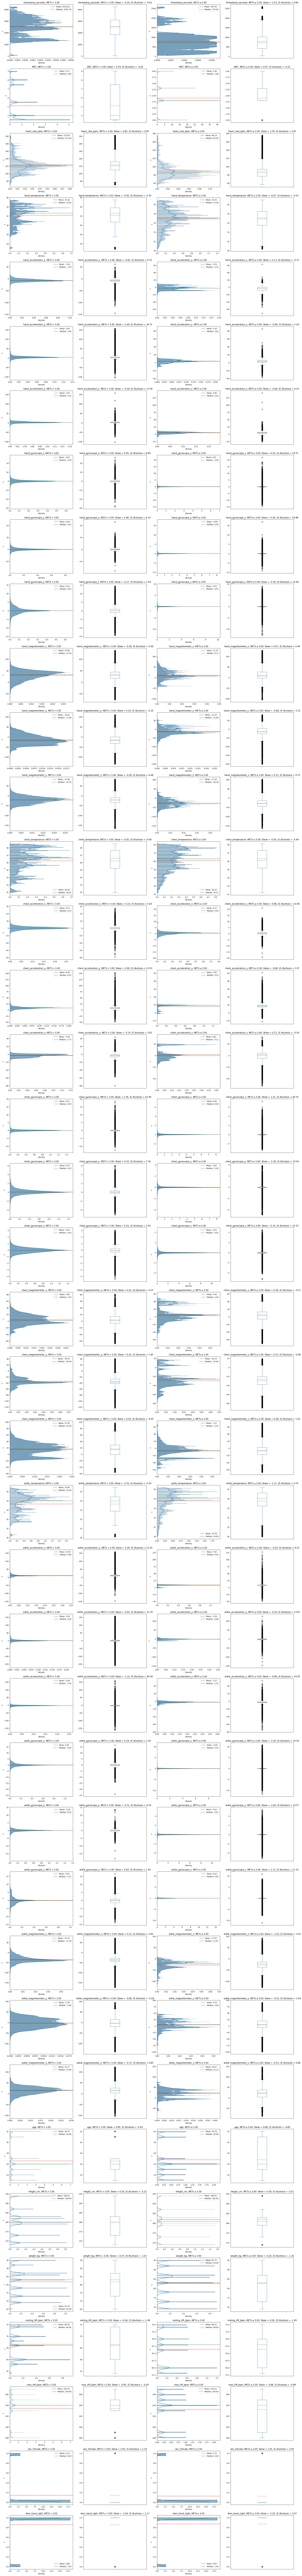

In [108]:
# Define function for plotting histograms
def plot_histogram(ax, data, column, thresh, ylabel):
    comparison_operator = ">" if data is df_sub_exc_active_active else "\leq"
    title = rf"{column}, $METs {comparison_operator} {thresh:.2f}$"
    sns.histplot(data=data, ax=ax, y=column, stat="density", kde=True)
    mean = data[column].mean()
    median = data[column].median()
    ax.axhline(mean, ls='--', color='r', label=f'Mean: {mean:.2f}')
    ax.axhline(median, ls='--', color='g', label=f'Median: {median:.2f}')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend()

# Define function for plotting box plots
def plot_boxplot(ax, data, column, thresh):
    comparison_operator = ">" if data is df_sub_exc_active_active else "\leq"
    skew, kurtosis = data[column].skew(), data[column].kurtosis()
    title = rf"{column}, $METs {comparison_operator} {thresh:.2f}$: Skew = {skew:.2f}, (E-)Kurtosis = {kurtosis:.2f}"
    data.plot(kind="box", y=column, ax=ax, meanline=True, showmeans=True, meanprops={"color":"r"})
    ax.set_xticklabels([""])
    ax.set_title(title)
    
# Create subplots
thresh = 3
fig, axes = plt.subplots(nrows=len(sig_cols), ncols=4, figsize=(23, 5 * len(sig_cols)))

for idx, col in enumerate(sig_cols):
    plot_histogram(axes[idx, 0], df_sub_exc_active_active, col, thresh, r"$x$")
    plot_boxplot(axes[idx, 1], df_sub_exc_active_active, col, thresh)
    plot_histogram(axes[idx, 2], df_sub_exc_active_sedentary, col, thresh, r"$x$")
    plot_boxplot(axes[idx, 3], df_sub_exc_active_sedentary, col, thresh)

plt.tight_layout()
plt.show()


Almost all the distributions do not have a bell curve shape.Skewness and kurtosis don't fall within the range of -0.5 to 0.5.

The above observations show non-Gaussian distributions so we will continue the bootstrapping process for correction.

In [109]:
norm_cols = []
not_norm_cols = [] 

for col in sig_cols:
    _,p_value_n_q = normaltest(df_sub_exc_active_active[col])
    _,p_value_n_lq = normaltest(df_sub_exc_active_sedentary[col])
    
    if (p_value_n_q < alpha) or (p_value_n_lq < alpha):
        print(f"KSquared: At least one {col} distribution is statistically not Gaussian at the {100*alpha}% significance level, ({p_value_n_q},{p_value_n_lq})")
        not_norm_cols.append(col)
    else:
        _,p_value_lf_q = lilliefors(df_sub_exc_active_active[col],dist="norm")
        _,p_value_lf_lq = lilliefors(df_sub_exc_active_sedentary[col],dist="norm")
        
        if (p_value_lf_q > alpha) and (p_value_lf_lq > alpha):
            print(f"Lilliefors: Both {col} distributions are statistically Gaussian at the {100*alpha}% significance level, ({p_value_lf_q},{p_value_lf_lq})")
            norm_cols.append(col)
        else:
            print(f"Lilliefors: At least one {col} distributions are not statistically Gaussian at the {100*alpha}% significance level, ({p_value_lf_q},{p_value_lf_lq})")
            not_norm_cols.append(col)

KSquared: At least one timestamp_seconds distribution is statistically not Gaussian at the 0.1% significance level, (0.0,0.0)
KSquared: At least one MET distribution is statistically not Gaussian at the 0.1% significance level, (0.0,0.0)
KSquared: At least one heart_rate_bpm distribution is statistically not Gaussian at the 0.1% significance level, (0.0,0.0)
KSquared: At least one hand_temperature distribution is statistically not Gaussian at the 0.1% significance level, (0.0,0.0)
KSquared: At least one hand_acceleration_x distribution is statistically not Gaussian at the 0.1% significance level, (0.0,0.0)
KSquared: At least one hand_acceleration_y distribution is statistically not Gaussian at the 0.1% significance level, (0.0,0.0)
KSquared: At least one hand_acceleration_z distribution is statistically not Gaussian at the 0.1% significance level, (0.0,0.0)
KSquared: At least one hand_gyroscope_x distribution is statistically not Gaussian at the 0.1% significance level, (0.0,0.0)
KSqua

Here bootstrapping will be conducted. 

Bootstrapping provides an alternative when traditional methods may not be applicable due to non-normality(not Gaussian). By resampling the data with replacement many times, it creates numerous simulated samples. This helps in approximating the sampling distribution of a statistic (like mean, median, or standard deviation), providing insights into its variability and bias.

In [110]:
def bootstrap_diff_means(data_1,data_2,num_bootstraps=1000,tail="two"):
    m_1 = np.mean(data_1)
    m_2 = np.mean(data_2)
    v_1 = np.var(data_1, ddof=1)
    v_2 = np.var(data_2, ddof=1)
    n_1 = len(data_1)
    n_2 = len(data_2)
    se = np.sqrt(v_1/n_1 + v_2/n_2)
    t_stat = (m_1 - m_2)/se

    comb_m = (np.sum(data_1) + np.sum(data_2))/(n_1 + n_2)

    adj_col1 = data_1 - m_1 + comb_m
    adj_col2 = data_2 - m_2 + comb_m

    count = 0
    for _ in range(num_bootstraps):
        bs_1 = np.array([adj_col1[i] for i in np.random.randint(0,n_1,size=n_1)])
        bs_2 = np.array([adj_col2[i] for i in np.random.randint(0,n_2,size=n_2)]) 
        
        bs_m_1 = np.mean(bs_1)
        bs_m_2 = np.mean(bs_2)
        bs_v_1 = np.var(bs_1,ddof=1)
        bs_v_2 = np.var(bs_2,ddof=1)
        bs_se = np.sqrt(bs_v_1/n_1 + bs_v_2/n_2)
        
        bs_t_stat = (bs_m_1 - bs_m_2)/bs_se
        
        if tail == "two":
            if np.abs(bs_t_stat) >= np.abs(t_stat):
                count += 1
        elif tail == "less":
            if bs_t_stat <= t_stat:
                count += 1
        elif tail == "greater":
            if bs_t_stat >= t_stat:
                count += 1

    return m_1 - m_2, t_stat, (count+1)/(num_bootstraps+1)

In [111]:
sig_mean_cols = []
dbars = []
for col in sig_cols:
    data_1 = df_sub_exc_active_active[col].to_numpy()
    data_2 = df_sub_exc_active_sedentary[col].to_numpy()
    if np.mean(data_1) - np.mean(data_2) < 0:
        tail = "less"
    else:
        tail = "greater"
    dbar, _, p_value_bs = bootstrap_diff_means(data_1,data_2,tail=tail)
    if p_value_bs < alpha:
        print(f"Bootstrap: There is significant evidence to state that the average {col} levels for METs > 3 is different to  METs <= 3 at the {100*alpha}% significance level, p-value = {p_value_bs}")
        sig_mean_cols.append(col)
        dbars.append(dbar)
    else:
        print(f"Bootstrap: There is not significant evidence to state that the average {col} levels for METs > 3 is different to METs <= 3 at the {100*alpha}% significance level, p-value = {p_value_bs}")

Bootstrap: There is significant evidence to state that the average timestamp_seconds levels for METs > 3 is different to  METs <= 3 at the 0.1% significance level, p-value = 0.000999000999000999
Bootstrap: There is significant evidence to state that the average MET levels for METs > 3 is different to  METs <= 3 at the 0.1% significance level, p-value = 0.000999000999000999
Bootstrap: There is significant evidence to state that the average heart_rate_bpm levels for METs > 3 is different to  METs <= 3 at the 0.1% significance level, p-value = 0.000999000999000999
Bootstrap: There is significant evidence to state that the average hand_temperature levels for METs > 3 is different to  METs <= 3 at the 0.1% significance level, p-value = 0.000999000999000999
Bootstrap: There is significant evidence to state that the average hand_acceleration_x levels for METs > 3 is different to  METs <= 3 at the 0.1% significance level, p-value = 0.000999000999000999
Bootstrap: There is significant evidence 

After completing bootstrapping, we found that most features significantly differ between Sedentary and Active groups at a strict 0.1% significance level, highlighting their distinct roles in differentiating activity groups. 

Next, we aim to evaluate the significance of these differences for each subject using a T-test.

In [112]:
def HR_activitylevel_subject(activitylevel,subject):    
    HR_level_and_subject=df_sub_exc[(df_sub_exc['active_or_sedentary']==str(activitylevel)) & 
                                  (df_sub_exc['subject_id']==str(subject))]["heart_rate_bpm"]
    return HR_level_and_subject

def ttest(subject):
    HR_activitylevel_subject('active',subject)
    HR_activitylevel_subject('sedentary',subject)

    mean1=HR_activitylevel_subject('active',subject).mean()
    var1=HR_activitylevel_subject('active',subject).var(ddof=1)
    n_obsvns1=len(HR_activitylevel_subject('active',subject))

    mean2=HR_activitylevel_subject('sedentary',subject).mean()
    var2=HR_activitylevel_subject('sedentary',subject).var(ddof=1)
    n_obvns2=len(HR_activitylevel_subject('sedentary',subject))

    res=stats.ttest_ind_from_stats(mean1, np.sqrt(var1), n_obsvns1,
                               mean2,np.sqrt(var2),n_obvns2,equal_var=False,alternative='greater')
    
    return list([str(subject), f'{res[0]:,.2f}'.format(res[0]), f'{res[1]:,.2f}'.format(res[1])])


ttests_summary=pd.DataFrame(columns=["subject_id","t-test","p-value"])
for i in range(1,10,1):
    ttests_summary.loc[ttests_summary.shape[0]]=ttest(100+i)
ttests_summary

# reference: example file 237779_DSRM Report 2-checkpoint

subject_id  t-test p-value
0        101  516.76    0.00
1        102  501.67    0.00
2        103  292.91    0.00
3        104  348.48    0.00
4        105  487.59    0.00
5        106  375.28    0.00
6        107  457.05    0.00
7        108  475.98    0.00
8        109     nan     nan

From the results, after conducting T-tests to evaluate differences between two groups, we observe that all subjects (except for 109, due to a lack of data) passed the test. 

This outcome is aligned with our findings from the bootstrapping analysis. 

Now, we are confident in using MET scores as the dependent variable and other variables that pass the normality test as independent variables in our regression model. 

Therefore, our aim is to identify the key factors that most significantly impact MET scores, meaning we seek to determine what can best predict the intensity of an activity.

In [20]:
df_sub_exc_model = df_sub_exc.copy()
df_sub_exc_model['subject_id'] = df_sub_exc_model['subject_id'].astype(int)
df_sub_exc_model_num = df_sub_exc_model.select_dtypes(include=[np.number])

In [114]:
y = df_sub_exc_model_num["MET"]
X = df_sub_exc_model_num.copy(deep=True)
X.drop(columns=["MET",],inplace=True)

min_num_features = 1
lm = LinearRegression()
K = 5

rfecv = RFECV(lm,min_features_to_select=min_num_features,cv=K).fit(X,y)
print(rfecv.n_features_)
print(rfecv.get_feature_names_out())

17
['subject_id' 'heart_rate_bpm' 'hand_temperature' 'hand_acceleration_z'
 'hand_gyroscope_x' 'hand_gyroscope_z' 'chest_gyroscope_x'
 'chest_gyroscope_y' 'chest_gyroscope_z' 'ankle_temperature'
 'ankle_gyroscope_x' 'ankle_gyroscope_y' 'age' 'resting_HR_bpm'
 'max_HR_bpm' 'sex_Female' 'dom_hand_right']


In this phase of our analysis, we employ Recursive Feature Elimination with Cross-Validation (RFECV) to identify the most relevant features for our regression model. RFECV stands out as an advanced feature selection method that not only tests the performance of various features within the model but also integrates the robustness of 5-fold cross-validation. In this process, the model iteratively uses 80% of the data for training and the remaining 20% for testing, ensuring that each segment of the data is utilized in the testing phase at least once.

The outcome from RFECV will be used in predicting the MET (Metabolic Equivalent of Task) score. 

Following the development of the model, we will conduct a thorough evaluation of the results to assess its predictive accuracy and overall effectiveness.


In [115]:
X = df_sub_exc_model_num[['subject_id', 'heart_rate_bpm','hand_temperature', 'hand_acceleration_z',
                          'hand_gyroscope_z', 'hand_gyroscope_x','chest_gyroscope_x','ankle_temperature','resting_HR_bpm',
                          'chest_gyroscope_y', 'chest_gyroscope_z','max_HR_bpm','sex_Female','dom_hand_right',
                          'ankle_gyroscope_x', 'ankle_gyroscope_y','age']]

y = df_sub_exc_model_num['MET']

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Adding a constant to the model (intercept)
x_train_with_const = sm.add_constant(x_train)
x_test_with_const = sm.add_constant(x_test) 

# Building the model with statsmodels
model = sm.OLS(y_train, x_train_with_const).fit()

# Creating a DataFrame for output
model_output_df = pd.DataFrame({
    'Coefficient': model.params,
    'P-Value': model.pvalues
})

# Formatting the coefficients
model_output_df['Coefficient'] = model_output_df['Coefficient'].apply(lambda x: '{:.2f}'.format(x))
y_pred = model.predict(x_test_with_const)
# Displaying the DataFrame
print(model_output_df)
MSE = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
R_sqrd = metrics.r2_score(y_test, y_pred)

# Print the results
print('-----------------------------------')
print('MSE = {:.2f}'.format(MSE))
print('R^2 = {:.2f}'.format(R_sqrd))


                    Coefficient        P-Value
const                    -29.45   0.000000e+00
subject_id                 0.30   0.000000e+00
heart_rate_bpm             0.06   0.000000e+00
hand_temperature          -0.10   0.000000e+00
hand_acceleration_z       -0.07   0.000000e+00
hand_gyroscope_z          -0.04   0.000000e+00
chest_gyroscope_x          0.08  2.553250e-280
ankle_temperature         -0.01   1.880823e-10
resting_HR_bpm             0.04   0.000000e+00
chest_gyroscope_y          0.39   0.000000e+00
chest_gyroscope_z          0.08  1.134374e-100
max_HR_bpm                -0.02  7.643949e-176
sex_Female                 0.41   0.000000e+00
dom_hand_right             1.25   0.000000e+00
ankle_gyroscope_x          0.06   0.000000e+00
ankle_gyroscope_y          0.08   0.000000e+00
-----------------------------------
MSE = 1.51
R^2 = 0.67


A high p-value suggests that the evidence is insufficient to conclude that the coefficient of that particular feature is significantly different from zero in the population from which the sample was drawn.

1. **Coefficient Equals Zero**: If a feature's coefficient is exactly zero, it implies that changes in this feature have no effect on the response variable.

2. **Coefficient Different from Zero**: If a feature's coefficient is significantly different from zero, it suggests that the feature does have an impact on the response variable.

reference: https://ecampusontario.pressbooks.pub/introstats/chapter/13-6-testing-the-regression-coefficients/

The initial regression model yielded an ${R^2}$ of 0.67 and an ${MSE}$ of 1.51, which is a respectable outcome for our initial attempt. Ideally, we aim for an ${R^2}$ above 0.7 and a lower ${MSE}$, as the lower the MSE, the better. This suggests that there is room for further improvement in our model.

In subsequent steps, we will explore various feature engineering and scaling techniques to enhance the model's overall accuracy.

In [116]:
# Creating the scaler object
df_master_f_eng = df_sub_exc.copy()
df_master_f_eng = pd.get_dummies(df_master_f_eng, columns=['active_or_sedentary'])
df_master_f_eng.drop(['active_or_sedentary_sedentary'],axis=1,inplace=True)
df_master_f_eng['active_or_sedentary_active'] = df_master_f_eng['active_or_sedentary_active'].astype(int)

# Compute mean and variance
trans_cols = ['heart_rate_bpm', 'hand_acceleration_x', 'hand_acceleration_y', 'hand_acceleration_z', 'chest_acceleration_x', 'chest_acceleration_y', 'chest_acceleration_z', 'ankle_acceleration_x', 'ankle_acceleration_y', 'ankle_acceleration_z', 'chest_gyroscope_x', 'chest_gyroscope_y', 'chest_gyroscope_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z']
for col in trans_cols:
    df_master_f_eng[col + '_avg'] = df_master_f_eng.groupby(['subject_id', 'activity_id'])[col].transform('mean')

In the given process, mean calculations are conducted and subsequently integrated back into the dataset `df_master_f_eng` as part of the feature engineering process. 

Feature engineering is a crucial step in enhancing model performance. By creating these engineered features, the regression model can achieve a more accurate and effective fit. This is because these new features often have additional information or patterns inherent in the data, which might not be immediately apparent from the original dataset. 

In [117]:
y = df_master_f_eng["MET"]
X = df_master_f_eng.copy(deep=True)
X.drop(columns=["MET",],inplace=True)

min_num_features = 1
lm = LinearRegression()
K = 5

rfecv = RFECV(lm,min_features_to_select=min_num_features,cv=K).fit(X,y)
print(rfecv.n_features_)
print(rfecv.get_feature_names_out())

25
['subject_id' 'activity_id' 'hand_temperature' 'chest_temperature'
 'ankle_temperature' 'age' 'max_HR_bpm' 'sex_Female' 'dom_hand_right'
 'active_or_sedentary_active' 'heart_rate_bpm_avg'
 'hand_acceleration_x_avg' 'hand_acceleration_y_avg'
 'hand_acceleration_z_avg' 'chest_acceleration_y_avg'
 'chest_acceleration_z_avg' 'ankle_acceleration_x_avg'
 'ankle_acceleration_y_avg' 'ankle_acceleration_z_avg'
 'chest_gyroscope_x_avg' 'chest_gyroscope_y_avg' 'chest_gyroscope_z_avg'
 'hand_gyroscope_x_avg' 'hand_gyroscope_y_avg' 'hand_gyroscope_z_avg']


For the second attempt, `MinMaxScaler` was introduced to the pre-processing stage. 

`MinMaxScaler` is a technique used to scale features to a specified range, often between 0 and 1. This scaling is achieved by transforming each feature individually based on the minimum and maximum values observed in the data. The transformation is as follows:

$[ \text{X}_{\text{scaled}} = \frac{\text{X} - \text{X}_{\text{min}}}{\text{X}_{\text{max}} - \text{X}_{\text{min}}}]$

`MinMaxScaler` is a simple yet effective method for scaling data, particularly when you need features on a common scale without distorting their distributions.

In [118]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

def scale_data(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return pd.DataFrame(X_train_scaled, columns=X_train.columns), pd.DataFrame(X_test_scaled, columns=X_test.columns)

def fit_ols_model(X_train, y_train):
    # Reset indices
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_train_with_const = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_with_const).fit()
    return model


def evaluate_model(model, X_test, y_test):
    X_test_with_const = sm.add_constant(X_test)
    y_pred = model.predict(X_test_with_const)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2, y_pred

def filter_pos_correlated_features(model):
    model_output_df = pd.DataFrame({
        'Coefficient': model.params,
        'P-Value': model.pvalues
    })
    model_output_df['Coefficient'] = model_output_df['Coefficient'].apply(lambda x: '{:.2f}'.format(x))
    model_output_df['P-Value'] = pd.to_numeric(model_output_df['P-Value'], errors='coerce')
    model_output_df['Coefficient'] = pd.to_numeric(model_output_df['Coefficient'], errors='coerce')

    pos_filtered_df = model_output_df[(model_output_df['P-Value'] < 0.01) & (model_output_df['Coefficient'] > 0.1)]
    return pos_filtered_df


X = df_master_f_eng[[
    'subject_id', 'activity_id', 'hand_temperature', 'chest_temperature',
    'ankle_temperature', 'age', 'max_HR_bpm', 'sex_Female', 'dom_hand_right',
    'active_or_sedentary_active', 'heart_rate_bpm_avg',
    'hand_acceleration_x_avg', 'hand_acceleration_y_avg',
    'hand_acceleration_z_avg', 'chest_acceleration_y_avg',
    'chest_acceleration_z_avg', 'ankle_acceleration_x_avg',
    'ankle_acceleration_y_avg', 'ankle_acceleration_z_avg',
    'chest_gyroscope_x_avg', 'chest_gyroscope_y_avg', 'chest_gyroscope_z_avg',
    'hand_gyroscope_x_avg', 'hand_gyroscope_y_avg', 'hand_gyroscope_z_avg'
]]

y = df_master_f_eng['MET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
model = fit_ols_model(X_train_scaled, y_train)
mse, r2, y_pred = evaluate_model(model, X_test_scaled, y_test)
pos_features = filter_pos_correlated_features(model)

print("Positively Correlated Features:")
print(pos_features)
print('-----------------------------------')
print('MSE = {:.2f}'.format(mse))
print('R^2 = {:.2f}'.format(r2))

Positively Correlated Features:
                            Coefficient  P-Value
subject_id                         1.49      0.0
activity_id                        1.76      0.0
hand_temperature                   1.07      0.0
sex_Female                         1.25      0.0
dom_hand_right                     0.60      0.0
active_or_sedentary_active         0.90      0.0
heart_rate_bpm_avg                 6.09      0.0
hand_acceleration_x_avg            0.71      0.0
hand_acceleration_y_avg            1.02      0.0
chest_acceleration_y_avg           0.82      0.0
chest_acceleration_z_avg           2.46      0.0
ankle_acceleration_x_avg           0.48      0.0
ankle_acceleration_y_avg           1.19      0.0
ankle_acceleration_z_avg           0.48      0.0
chest_gyroscope_x_avg              0.83      0.0
chest_gyroscope_y_avg              4.52      0.0
hand_gyroscope_z_avg               0.71      0.0
-----------------------------------
MSE = 0.22
R^2 = 0.95


The second regression model yielded an ${R^2}$ of 0.95 and an ${MSE}$ close to 0.22. An MSE of 0.22 (Mean Squared Error) indicates the average squared difference between the observed actual outturns and the model's predictions. Lower values of MSE indicate better fit.

We have found the features that have the statistical significance of each coefficient, meaning in the model, we filtered those features whose p-values less than 0.01, indicating strong evidence against the null hypothesis (which stated that the feature has no effect on the dependent variable).

Here’s an interpretation of the coefficients:

- The `heart_rate_bpm_avg` measurements show the most substantial positive relationship 6.09 with the MET score, which mekes sense since during physical activities or exercises, the heart rate increases to supply more oxygen and nutrients to the muscles, which in turn increases energy expenditure. 

- `chest_gyroscope_y_avg` (chest 3D-gyroscope -2 ) has the high positive coefficient of 4.52. For activities that involve significant upper body movement or rotation, such as running, cycling, or even certain types of work-related activities, the chest gyroscope readings can be particularly informative.

- `activity_id` also contribute 1.76 positive coefficient to MET score, meaning we can use the sequence of the activity ID to predict MET socre.

- `ankle_acceleration_y_avg`(ankle - 3D-acceleration scale: ±16g, resolution: 13-bit -2) has 1.19 positive coefficient to MET score. This aligns with the understanding that activities involving higher levels of lower-body movement, particularly those that increase vertical acceleration at the ankle (such as running or jogging), are often associated with increased energy expenditure.

- Other features showing a positive relationship with predicting the MET score include `chest_gyroscope_x_avg`, `chest_acceleration_z_avg`, `active_or_sedentary_active`, `hand_temperature`, `hand_acceleration_x_avg`,`hand_acceleration_y_avg ` and `hand_gyroscope_z_avg`.

- `sex_Female` and `dom_hand_right` also show a strong positive relationship with MET. This implies that, within the dataset, being female and having a dominant right hand are associated with higher MET scores.However, The dataset might contain underlying biases. Further investigation is necessary to understand these associations fully.

The results logically conclude that when assessing the intensity of exercise, heart rate and chest movement are critical factors when predicting MET score.

--------------------------------------

We will focus on features that exhibit a positive relationship with MET for conducting PCA (Principal Component Analysis) and clustering. This approach is chosen to explore whether we can effectively segment our customers based on these specific features. If successful, this segmentation will allow us to design tailored workout strategies to meet the distinct needs of different customer groups.

PCA is employed for dimensionality reduction. It achieves this by transforming the original dataset into a new set of variables, known as principal components. These components are orthogonal, meaning they are uncorrelated with each other in the multi-dimensional space. This property of PCA ensures that the principal components provide a simplified yet comprehensive representation of our dataset, focusing on the most significant variance and patterns present.

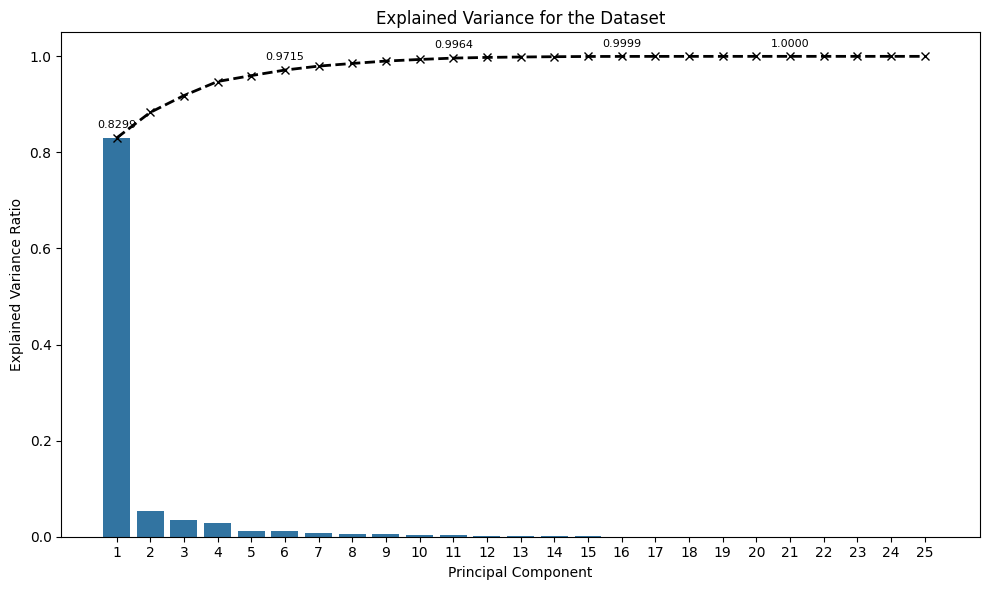

In [119]:
from sklearn.decomposition import PCA
data = df_master_f_eng[['subject_id', 'activity_id', 'hand_temperature', 'chest_temperature',
    'ankle_temperature', 'age', 'max_HR_bpm', 'sex_Female', 'dom_hand_right',
    'active_or_sedentary_active', 'heart_rate_bpm_avg',
    'hand_acceleration_x_avg', 'hand_acceleration_y_avg',
    'hand_acceleration_z_avg', 'chest_acceleration_y_avg',
    'chest_acceleration_z_avg', 'ankle_acceleration_x_avg',
    'ankle_acceleration_y_avg', 'ankle_acceleration_z_avg',
    'chest_gyroscope_x_avg', 'chest_gyroscope_y_avg', 'chest_gyroscope_z_avg',
    'hand_gyroscope_x_avg', 'hand_gyroscope_y_avg', 'hand_gyroscope_z_avg']]

pca = PCA().fit(data)
comps = pca.components_
ev_ratio = pca.explained_variance_ratio_ 
cumul_ev_ratio = np.cumsum(ev_ratio)
pcs = np.arange(1,len(data.columns)+1)
loadings = pd.DataFrame(data=comps,columns=[f"PC{pc}" for pc in pcs],index=data.columns)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(x=pcs, y=ev_ratio, ax=ax)
ax.plot(pcs-1, cumul_ev_ratio, ls="--", marker="x", lw=2, c="k")

# Adjust the annotations to avoid overlap
for i, (pc, cer) in enumerate(zip(pcs, cumul_ev_ratio)):
    if i % 5 == 0:  # Adjust the modulo value to change the annotation frequency
        ax.annotate(f"{cer:.4f}", xy=(pc-1, cer + 0.02), ha='center', fontsize=8)  # Adjust text alignment and size

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("Explained Variance for the Dataset")
plt.tight_layout()  # Adjust layout to fit annotations
plt.show()


We can observe that the cumulative variance explained by the first two principal components (PC1 and PC2) accounts for approximately 87% of the total variance in our data. This observation aligns with the common rule of thumb in PCA, which suggests selecting enough dimensions to explain between 70-90% of the overall data variance. Achieving this level of explained variance ensures that we retain the majority of significant information present in the dataset while reducing its complexity.

Below, we have detailed the coefficients for each feature in the PCA. These coefficients, also known as loadings, indicate the contribution of each feature to the respective principal components. Understanding these loadings helps in interpreting the principal components and the underlying structure of the data.

In [120]:
elbow = 2
components = [f"PC{i}" for i in range(1,elbow+1)]
loadings[components]

PC1           PC2
subject_id                 -1.271267e-02  7.621781e-02
activity_id                -2.049161e-03 -8.231183e-01
hand_temperature            1.709554e-01  3.309392e-01
chest_temperature          -1.626821e-01  3.784169e-01
ankle_temperature           1.725578e-01 -4.693004e-02
age                        -3.761883e-01 -1.783348e-01
max_HR_bpm                  3.683381e-01 -2.513536e-02
sex_Female                  3.919182e-02  6.571771e-03
dom_hand_right              2.778309e-01  8.482214e-02
active_or_sedentary_active  6.748436e-01 -8.686027e-02
heart_rate_bpm_avg         -3.635723e-02 -9.133915e-02
hand_acceleration_x_avg    -1.848184e-01 -1.785881e-02
hand_acceleration_y_avg    -2.251870e-01  7.471549e-02
hand_acceleration_z_avg     7.416705e-02  2.398991e-03
chest_acceleration_y_avg    6.528192e-02 -8.676178e-03
chest_acceleration_z_avg    3.534978e-02 -4.960795e-03
ankle_acceleration_x_avg    3.510207e-02  1.130824e-02
ankle_acceleration_y_avg    2.419896e-02 -1.261415e-03
ankle_acceleration_z_avg    6.265727e-02 -4.852576e-03
chest_gyroscope_x_avg       4.704023e-04 -1.259559e-04
chest_gyroscope_y_avg      -8.977109e-03 -4.532006e-03
chest_gyroscope_z_avg      -1.971777e-03  1.406835e-03
hand_gyroscope_x_avg       -2.378699e-03  1.169099e-03
hand_gyroscope_y_avg        1.106233e-03  2.252844e-04
hand_gyroscope_z_avg        2.290035e-14  5.441439e-16

#### PC1
- High Positive Loadings: Features like active_or_sedentary_active, max_HR_bpm, and hand_temperature have high positive loadings, indicating a strong positive contribution to PC1.

- High Negative Loadings: age has a notably high negative loading, suggesting it contributes inversely to PC1.

#### PC2

- High Positive Loadings: chest_temperature and hand_temperature have high positive loadings on PC2.

- High Negative Loadings: The most significant negative loading is on activity_id.

Now, we will employ the elbow method to determine the optimal number of clusters for K-means analysis. 

The elbow method is used to identify the point at which the within-cluster sum of squares (WCSS) begins to diminish at a decreasing rate. 

WCSS is calculated for different numbers of clusters (k). It is defined as the sum of the squared distances between each point in a cluster and the centroid of that cluster. Mathematically, for k clusters, it is expressed as:

   $\text{WCSS}(k) = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$

   Here, $( C_i )$ is the set of points in cluster i, and $( \mu_i )$ is the centroid of cluster i.

**This suggests that adding more clusters beyond this point does not significantly improve the distinctness of the clustering. 
This method enables the most distinct and meaningful separation of the data.**
    

reference: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/#:~:text=The%20elbow%20method%20is%20a%20technique%20used%20in%20clustering%20analysis,Q2.

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

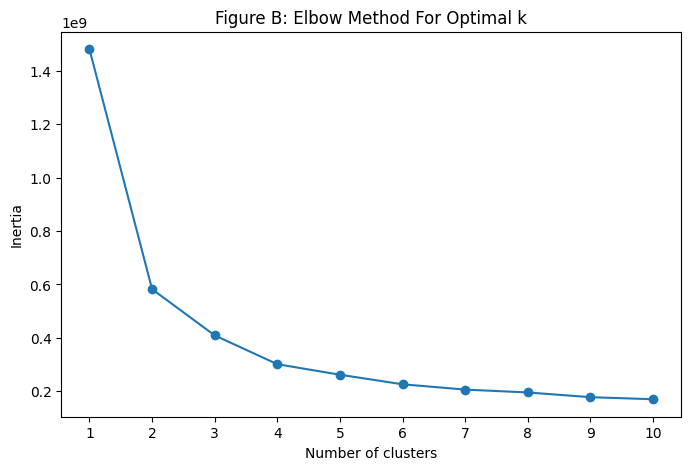

In [121]:
# Trying different numbers of clusters
range_of_clusters = range(1, 11)  # Testing from 1 to 10 clusters
inertia = []

for k in range_of_clusters:
    model = KMeans(n_clusters=k, init='k-means++', random_state=42)
    model.fit(data)
    inertia.append(model.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range_of_clusters, inertia, marker='o')
plt.title('Figure B: Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range_of_clusters)
plt.show()

**For our clustering analysis, we have decided to use 2 as the number of clusters from the results shown in the plot we generated using the elbow method. This choice also aligns with the two prominent peaks we observed in Figure A and the results from our PCA, specifically PCA2. The number 2 here represents the most meaningful way to group our data into two distinct categories(active and sedentary), which again further prove our initial hypothesis.**

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


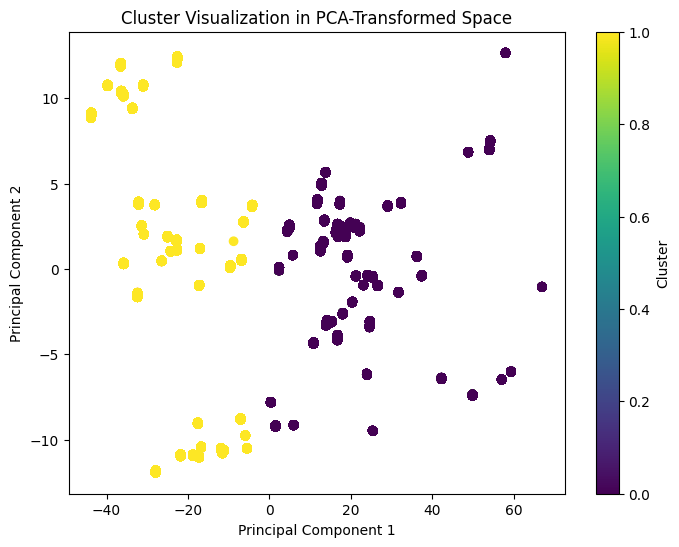

In [122]:
data = df_master_f_eng[[
    'subject_id', 'activity_id', 'hand_temperature', 'chest_temperature',
    'ankle_temperature', 'age', 'max_HR_bpm', 'sex_Female', 'dom_hand_right',
    'active_or_sedentary_active', 'heart_rate_bpm_avg',
    'hand_acceleration_x_avg', 'hand_acceleration_y_avg',
    'hand_acceleration_z_avg', 'chest_acceleration_y_avg',
    'chest_acceleration_z_avg', 'ankle_acceleration_x_avg',
    'ankle_acceleration_y_avg', 'ankle_acceleration_z_avg',
    'chest_gyroscope_x_avg', 'chest_gyroscope_y_avg', 'chest_gyroscope_z_avg',
    'hand_gyroscope_x_avg', 'hand_gyroscope_y_avg', 'hand_gyroscope_z_avg'
]]

# Transform the data using the first two principal components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Perform K-Means Clustering with n_clusters = 2
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(data_pca)

# Visualizing the results (using the first two principal components)
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization in PCA-Transformed Space')
plt.colorbar(label='Cluster')
plt.show()


The outcome of the clustering model shows significant variation (active and sedentary groups).

I have found that the key measurements for two groups of people in this experiment.

It may therefore be adivisable to include the model when designing the calibration of a tracking device. 

# Conclusion

In our study, we first performed data cleaning on the dataset, addressing issues like data types, outliers, duplicates, and missing values. Particularly for heart rate data, missing values were backfilled, assuming heart rate consistency over time. We then divided the dataset into two groups based on identifiable peaks from their histograms in Figure A. The groups' statistical difference was confirmed using the Kolmogorov-Smirnov test and a Student's T-test, after ensuring normality through bootstrapping.

Feature selection for our regression model was done using Recursive Feature Elimination with Cross-Validation (RFECV), focusing on features that passed the normality check. Our initial model attempt resulted in an MSE of 1.51 and an R² of 0.67. After applying feature engineering and normalization (Min-Max Scalar), the model's performance improved significantly in the second attempt, yielding an MSE close to 0.22 and an R² of 0.95.

Then, We used features with a positive relationship with MET from the regresson model for conducting PCA (Principal Component Analysis) and clustering. This was to see if we could segment our customers effectively based on these attributes. Successful segmentation would enable us to create customized workout plans for different customer groups.

## Business Recommendations:

1. Focus on activities with higher `activity_id` values, correlating with higher MET scores, when developing fitness programs. This aligns with promoting more energy-intensive activities to increase physical activity levels effectively.

2. Implement `heart rate` monitoring features to ensure individuals are working at the correct intensity for their fitness goals. This data can also be used for overall health assessment, recovery monitoring, and early detection of potential health issues.

3. Prioritize investment in the chest and ankle sensors, for accurate monitoring of physical activity. Utilize `chest 3D-gyroscope -2` and `ankle - 3D-acceleration scale: ±16g, resolution: 13-bit -2` data for real-time feedback and personalized workout adjustments.

4. Given the result of the clustering (`we found two main groups of customers: active and sedentary groups`), also design product features that encourage light movements or exercises. This approach helps in catering to a wider audience, including those with sedentary lifestyles.

5. Use the developed algorithms to leverage this data to provide `customized exercise recommendations`. Create a `software applications` that provide users with in-depth insights, analytics, and visualizations based on their sensor data. Offer features such as workout summaries, health tips, and progress tracking to enrich the user experience.

------------------------------------

In [25]:
import io
from nbformat import read

# write the notebook filepath here
# make sure that the notebook is also in the same directory as this code
filepath="DSRM_Final.ipynb"

with io.open(filepath, "r", encoding="utf-8") as f:
    nb=read(f, 4)
word_count = 0
for cell in nb["cells"]:
    if cell.cell_type == "markdown":
        word_count += len(cell["source"].replace("#", "").lstrip().split(" "))
print(f"Submission length is {word_count}")

Submission length is 3976
